In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from gwaxion import physics
import pandas as pd

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)


# Fast method

## Fixed initial spin

In [5]:
# create an array of BH masses in LIGO's band
n_mass = 500
n_alpha = 20

distance = 5E6 * physics.PC_SI
chi_i = 0.7

mbh_ex = 60

In [6]:
import multiprocessing

mbhs_array = np.logspace(0, 3, n_mass)
alphas_array = np.linspace(0.01, 0.2, n_alpha)

a_m_list = []
for a in alphas_array:
    for m in mbhs_array:
        a_m_list.append([a, m])
        
# simple wrapper to get h0, fgw
def get_h0f(a_m):
    alpha, mbh = a_m
    return physics.get_gw_and_times(alpha, m_bh=mbh, chi_bh=chi_i, lgw=2, l=1, m=1, nr=0, distance=5E6*physics.PC_SI)

pool = multiprocessing.Pool(8)
h0_f_Ti_list = pool.map(get_h0f, a_m_list)

h0s, fgws, Tis = np.array(h0_f_Ti_list).T
alphas, mbhs = np.array(a_m_list).T

In [18]:
# get maximum amplitude per mass

df1 = pd.DataFrame({'h0': h0s.flatten(), 'fgw': fgws.flatten(), 'mbhs': mbhs.flatten(), 'tinst': Tis})
df1 = df1[(df1['h0']>0)&(df1['fgw']>0)]

grouped = df1.groupby('mbhs')
fgwmaxs = []
for mbh in mbhs_array.flatten():
    df_mbh = grouped.get_group(mbh)
    fgwmaxs.append(df_mbh['fgw'][df_mbh['h0']==df_mbh['h0'].max()].iloc[0])

In [33]:
reload(physics)

from scipy.optimize import brentq

f1yrs = []
sliced_mbhs = mbhs_array[0:-1:4]
for mass in sliced_mbhs:
    # find alpha for which Tinst = 1 year
    def d_tinst_fixed_chi(alpha): return physics.tinst_approx(mass, alpha, chi_i) - physics.YRSID_SI
    alpha_1yr = brentq(d_tinst_fixed_chi, 0.0001, 0.2,)
    _, fgw = physics.get_gw(alpha_1yr, m_bh=mass, chi_bh=chi_i)
    f1yrs.append(fgw)

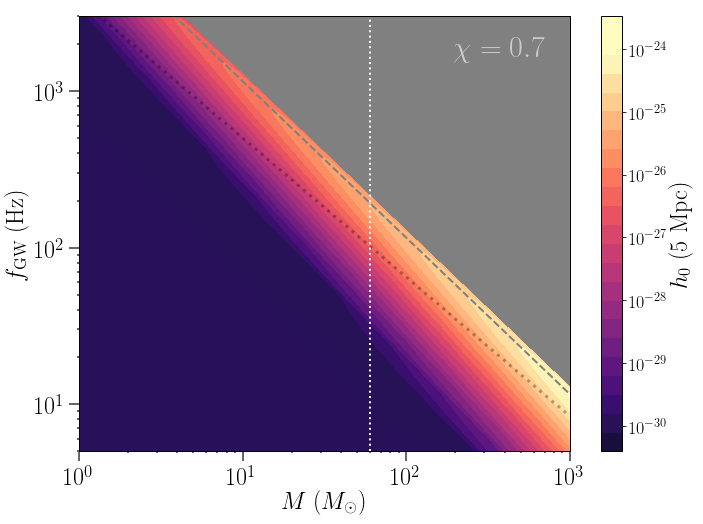

In [48]:
# FILLED CONTOUR PLOT

h0s_2 = h0s.copy()
h0s_2[(h0s_2<=1E-30)&(h0s_2>0)] = 1E-30
h0s_ma = np.ma.masked_array(h0s_2, mask=(np.isnan(h0s_2)))

norm = matplotlib.colors.LogNorm(vmin=1E-31, vmax=h0s_ma.max())

X = df1['mbhs'].reshape(n_alpha, n_mass)
Y = df1['fgw'].reshape(n_alpha, n_mass)
Z = h0s_ma.reshape(n_alpha, n_mass)

fig, ax = plt.subplots(1, figsize=(11,8))

# manually fill the lower-left corner which otherwise looks gray
ax.fill_between(mbhs_array, 0, fgwmaxs, facecolor='#281159')

# plot contours
cm = ax.contourf(X, Y, Z, locator=ticker.LogLocator(numticks=100,base=2), cmap='magma', norm=norm)

#cs = plt.contour(mbhs,fgws_ma, h0s_ma, ticklocation=ticker.LogLocator(), colors='lavender', norm=norm)
# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()
# plt.clabel(cs, cs.levels, inline=True, fontsize=8, fmt=fmt, loc='best')

# plot peak-amplitude line
ax.plot(mbhs_array, fgwmaxs, '--', color='gray', lw=2)

# plot 1yr-Tinst line
ax.plot(sliced_mbhs, f1yrs, ':', color='k', lw=3, alpha=0.3)

# plot vertical line at 50 Msun
ax.axvline(mbh_ex, c='w', ls=':', lw=2)

# add colorbar
cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$h_0$ (5 Mpc)', ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylim(5, 3E3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f_{\rm GW}$ (Hz)')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

ax.annotate(r'$\chi=0.7$', xy=(0.95, 0.96), xycoords="axes fraction", 
            ha='right', va='top', fontsize=30, color='0.8')

fig.savefig('cmap_fgw_mbh_h0.pdf', bbox_inches='tight')

plt.show()
plt.close()

## Fixed initial mass

In [74]:
# create an array of BH spins in LIGO's band
n_spins = 100
n_alpha = 200

chis_array = np.linspace(0, 1, n_spins)
alphas_array = np.linspace(0.01, physics.get_alpha_max(0.7)+0.1, n_alpha)

a_chi_list = []
for a in alphas_array:
    for chi in chis_array:
        a_chi_list.append([a, chi])
        
# simple wrapper to get h0, fgw
def get_h0f(a_chi):
    alpha, chi = a_chi
    return physics.get_gw(alpha, m_bh=mbh_ex, chi_bh=chi, lgw=2, l=1, m=1, nr=0, distance=5E6*physics.PC_SI)

pool = multiprocessing.Pool(8)
h0_f_list = pool.map(get_h0f, a_chi_list)

h0s, fgws = np.array(h0_f_list).T
alphas, chis = np.array(a_chi_list).T

In [75]:
# get maximum amplitude per spin

df2 = pd.DataFrame({'h0': h0s.flatten(), 'fgw': fgws.flatten(), 'chi': chis.flatten()})
#df2 = df2[(df2['h0']>0)&(df2['fgw']>0)]

grouped = df2.groupby('chi')
new_chis = grouped.groups.keys()
fgwmaxs = []
for chi in new_chis:
    df_chi = grouped.get_group(chi)
    fgwmaxs.append(df_chi['fgw'][df_chi['h0']==df_chi['h0'].max()].iloc[0])
chi_df = pd.DataFrame({'chi': new_chis, 'fgw': fgwmaxs})
chi_df.sort_values('chi', inplace=True)
#chi_df = chi_df[chi_df['chi']>=0.2]

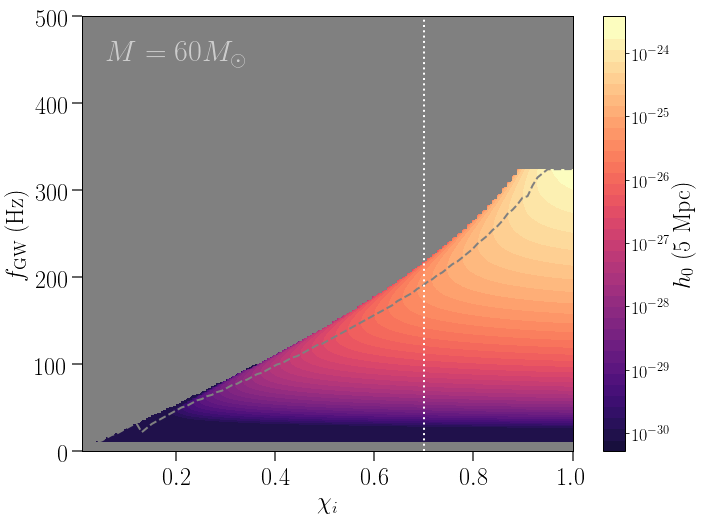

In [76]:
# FILLED CONTOUR PLOT
h0s_2 = h0s.copy()
h0s_2[(h0s_2<=1E-30)&(h0s_2>0)] = 1E-30
h0s_ma = np.ma.masked_array(h0s_2, mask=(np.isnan(h0s_2)))

norm = matplotlib.colors.LogNorm(vmin=1E-31, vmax=h0s_ma.max())

X = df2['chi'].reshape(n_alpha, n_spins)
Y = df2['fgw'].reshape(n_alpha, n_spins)
Z = h0s_ma.reshape(n_alpha, n_spins)

fig, ax = plt.subplots(1, figsize=(11,8))

cm = ax.contourf(X, Y, Z, locator=ticker.LogLocator(numticks=500,base=1.5), cmap='magma', norm=norm)
#cs = plt.contour(mbhs,fgws_ma, h0s_ma, ticklocation=ticker.LogLocator(), colors='lavender', norm=norm)
# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()
# plt.clabel(cs, cs.levels, inline=True, fontsize=8, fmt=fmt, loc='best')

ax.plot(chi_df['chi'], chi_df['fgw'], '--', color='gray', lw=2)

# plot vertical line at 0.7
ax.axvline(0.7, c='w', ls=':', lw=2)

# cbaxes = inset_axes(ax, width="70%", height="5%", loc=9)
cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$h_0$ (5 Mpc)', ticks=cb_ticks)#, orientation='horizontal', cax=cbaxes)
cb.ax.tick_params(labelsize=18) 

ax.set_ylabel(r'$f_{\rm GW}$ (Hz)')
ax.set_xlabel(r'$\chi_i$')
ax.set_xlim(0.01,1)
ax.set_ylim(0, 500)

ax.patch.set_facecolor("grey")

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

ax.annotate(r'$M=%i M_\odot$' % mbh_ex, xy=(0.05, 0.94), xycoords="axes fraction", 
            ha='left', va='top', fontsize=30, color='0.8')

fig.savefig('cmap_fgw_chi_h0.pdf', bbox_inches='tight')

plt.show()
plt.close()